In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde

In [2]:
from numba import vectorize, float64, guvectorize, jit

## LOAD DATASET

In [3]:
# GENERATE DATA FROM STABLE DISTRI
@jit(nopython=True)
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    V = np.pi / 2 * (2 * np.random.rand(num_datasets, dataset_size) - 1)
    W = - np.log(np.random.rand(num_datasets, dataset_size))
    #r = np.zeros(n)

    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        b = math.atan(const)
        s = (1 + const * const)**(1 / (2 * alpha))
        r = s * np.sin(alpha * V + b) / ((np.cos(V)) ** (1/alpha)) * (( np.cos( (1-alpha) * V - b ) / W )**((1-alpha)/alpha))
        r = gamma * r + delta
    else:
        piover2 = np.pi / 2
        sclshftV = piover2 + beta * V
        r = 1/piover2 * (sclshftV * np.tan(V) - beta * np.log( (piover2 * W * np.cos(V) ) / sclshftV ))
        r = gamma * r + (2 / np.pi) * beta * gamma * np.log(gamma) + delta
    return r

actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 10)
actual_data

array([[ 3.10334240e+00, -8.20269733e-01,  2.02408849e+00, ...,
        -7.34231436e-02,  5.87127702e-01,  8.51459352e-01],
       [ 1.04282853e+00, -7.59349420e-01, -1.93519969e-01, ...,
        -5.42601657e-01, -6.58064509e-01,  8.31184663e-01],
       [-2.02806617e+01, -1.14929097e+00, -8.75021203e-01, ...,
        -3.87316728e+00,  5.52505739e-01, -2.66971040e+00],
       ...,
       [-1.37563902e+00,  4.73563562e-01,  8.59814203e-01, ...,
        -1.48108295e+00, -7.50481972e-01, -1.16642804e+00],
       [ 1.82240572e+01, -8.71366967e-03, -5.22183901e-01, ...,
        -8.32447086e-01, -1.36764217e+00,  2.22266119e+00],
       [-4.79991064e-01, -5.19870529e-01,  3.49494630e+00, ...,
         5.74678371e-01,  6.13443999e-01,  3.90849562e-01]])

In [4]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data: np.ndarray) -> np.ndarray:
  # Compute quantile statistics
  v_stability = (np.percentile(data, 95) - np.percentile(data, 5)) / (np.percentile(data, 75) - np.percentile(data, 25))
  v_skewness = (np.percentile(data, 95) + np.percentile(data, 5) - 2 * np.percentile(data, 50)) / (np.percentile(data, 95) - np.percentile(data, 5))
  v_scale = (np.percentile(data, 75) - np.percentile(data, 25)) / 1
  v_loc = np.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = np.array([[0.0,    0.0,    0.0,    0.0,  0.0],  
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = max(np.append(0, np.argwhere(tv_stability <= v_stability)))
  tv_stability_i2 = min(np.append(14, np.argwhere(tv_stability >= v_stability)))
  tv_skewness_i1 = max(np.append(0, np.argwhere(tv_skewness <= abs(v_skewness))))
  tv_skewness_i2 = min(np.append(6, np.argwhere(tv_skewness >= abs(v_skewness))))
  dist_stability = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]
  if dist_stability != 0:
    dist_stability = (v_stability - tv_stability[tv_stability_i1]) / dist_stability

  dist_skewness = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = np.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = max(np.append(0, np.argwhere(t_stability >= alpha)))
  t_stability_i2 = min(np.append(15, np.argwhere(t_stability <= alpha)))
  t_skewness_i1 = max(np.append(0, np.argwhere(t_skewness <= abs(beta))))
  t_skewness_i2 = min(np.append(4, np.argwhere(t_skewness >= abs(beta))))

  dist_stability = t_stability[t_stability_i2] - t_stability[t_stability_i1]
  if dist_stability != 0:
    dist_stability = (alpha - t_stability[t_stability_i1]) / dist_stability

  dist_skewness = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = np.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + np.percentile(data, 50)

  if abs(alpha-1) < 0.05:
    mu = zeta
  else:
    mu = zeta - beta * sigma * math.tan(0.5 * math.pi *alpha)

  return np.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([1.57924582, 0.70325626, 1.05457368, 0.02475426])

In [5]:
@jit
def summary_statistics(theta, n_samples, n_datasets):
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = np.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [6]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 100 # number of datasets
        self.gamma_samples = 20
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.num_latent = np.shape(actual_summary_statistics)[0]
        self.lambda_dim = (self.num_coeffs) + int(((self.num_coeffs) * ((self.num_coeffs) + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def mean_adjustment_summary_statistics(self, adjusted_theta):
        theta = adjusted_theta[0:self.num_coeffs]
        Gamma = adjusted_theta[-self.num_latent:]
        sample_mean, sample_variance = summary_statistics(theta, 200, self.num_datasets)
        adjusted_sample_mean = sample_mean + np.diag(np.sqrt(sample_variance)) @ Gamma
        return adjusted_sample_mean, sample_variance

    def theta_prior(self, theta): 
        log_prior = multivariate_normal.logpdf(theta, cov= 100 * np.identity(self.num_coeffs))
        
        return log_prior

    def Gamma_prior(self, Gamma, scale):
        log_prior_gamma = []
        for j in range(len(Gamma)):
            log_prior_gamma.append(-np.log(2 * scale)-1/scale * np.abs(Gamma[j]))
        log_prior_Gamma = np.sum(log_prior_gamma)
        return log_prior_gamma, log_prior_Gamma

    # def unbiased_log_likelihood(self, theta):
    #     sample_mean = self.summary_statistics(theta)[0]
    #     sample_variance = self.summary_statistics(theta)[1]
    #     diff_mean_s = self.actual_summary_statistics - sample_mean
    #     part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    #     u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    #     return u_est_log_likelihood

    def mean_adjustment_unbiased_log_likelihood(self, adjusted_theta):
        adjusted_sample_mean = self.mean_adjustment_summary_statistics(adjusted_theta)[0]
        sample_variance = self.mean_adjustment_summary_statistics(adjusted_theta)[1]
        diff_mean_s = self.actual_summary_statistics - adjusted_sample_mean
        part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
        ma_u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - (self.num_coeffs + self.num_latent) - 2) / (2 * (self.num_datasets-1)) * part1
        return ma_u_est_log_likelihood

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        gradient_log_q_l = (np.diag(1 / np.diag(l)) - np.matmul(((np.reshape(theta - mu, ((self.num_coeffs),1))) * theta - mu), l)).T[np.triu_indices((self.num_coeffs))] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:(self.num_coeffs)])
        c_vech_l = np.array(c[(self.num_coeffs):])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        #mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * (self.num_coeffs))
        l_0 = np.tril(np.identity((self.num_coeffs)) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices((self.num_coeffs))]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in range(self.samples):
                    # True params have been reparam into epsilon
                    # GENERATE THETA
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1.1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (np.exp(theta_tilde_0[1]) - 1) / (np.exp(theta_tilde_0[1]) + 1)
                    gamma_0 = np.exp(theta_tilde_0[2])
                    delta_0 = theta_tilde_0[3]
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])

                    ma_unbiased_log_likelihood_init = []
                    # GENERATE GAMMA
                    for g in range(self.gamma_samples):
                        Gamma_init = np.random.laplace(scale = 0.5, size = self.num_latent)
                        adjusted_theta_0 = np.concatenate((theta_0, Gamma_init))
                        ma_unbiased_log_likelihood_init.append(self.mean_adjustment_unbiased_log_likelihood(adjusted_theta_0))
                    # Find gradient of LB
                    h_lambda_init = self.theta_prior(theta_tilde_0) + np.mean(ma_unbiased_log_likelihood_init) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]

                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]
                
                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1.1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (np.exp(theta_tilde_q[1]) - 1) / (np.exp(theta_tilde_q[1]) + 1)
                    gamma_q = np.exp(theta_tilde_q[2])
                    delta_q = theta_tilde_q[3]
                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    ma_unbiased_log_likelihood = []
                    # GENERATE GAMMA
                    for g in range(self.gamma_samples):
                        Gamma = np.random.laplace(scale = 0.5, size = self.num_latent)
                        adjusted_theta_q = np.concatenate((theta_q, Gamma))
                        ma_unbiased_log_likelihood.append(self.mean_adjustment_unbiased_log_likelihood(adjusted_theta_q))

                    # Find gradient of LB
                    h_lambda = self.theta_prior(theta_tilde_q) + np.mean(ma_unbiased_log_likelihood) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [7]:
# Set hyperparameters
stop = 5000

In [8]:
vb = GVB(200, actual_summary_statistics, 0.001, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_21000\4237580040.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "summary_statistics" failed type inference due to: No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(undefined, 1d, C), int64, array(float64, 1d, C))
 
There are 16 candidate implementations:
  - Of which 16 did not match due to:
  Overload of function 'setitem': File: <numerous>: Line N/A.
    With argument(s): '(array(undefined, 1d, C), int64, array(float64, 1d, C))':
   No match.

During: typing of setitem at C:\Users\admin\AppData\Local\Temp\ipykernel_21000\4237580040.py (4)

File "C:\Users\admin\AppData\Local\Temp\ipykernel_21000\4237580040.py", line 4:
def summary_statistics(theta, n_samples, n_datasets):
    <source elided>
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
   

LB -24.23562246649853


  0%|          | 2/5000 [01:55<79:59:47, 57.62s/it]

LB -23.66832816355726


  0%|          | 3/5000 [02:48<76:35:23, 55.18s/it]

LB -23.979348198518426


  0%|          | 4/5000 [03:42<76:06:36, 54.84s/it]

LB -23.450849436857734


  0%|          | 5/5000 [04:36<75:37:29, 54.50s/it]

LB -23.506976008754307


  0%|          | 6/5000 [05:29<74:46:41, 53.90s/it]

LB -23.67607662115734


  0%|          | 7/5000 [06:22<74:43:12, 53.87s/it]

LB -22.571644539254873


  0%|          | 8/5000 [07:16<74:37:02, 53.81s/it]

LB -23.523413134940885


  0%|          | 9/5000 [08:11<75:02:37, 54.13s/it]

LB -23.049238136519257


  0%|          | 10/5000 [09:04<74:20:59, 53.64s/it]

LB -23.770202637482647


  0%|          | 11/5000 [09:56<73:50:22, 53.28s/it]

LB -23.66170311215961


  0%|          | 12/5000 [10:48<73:12:23, 52.84s/it]

LB -23.139665237492817


  0%|          | 13/5000 [11:40<72:59:31, 52.69s/it]

LB -23.158117300174325


  0%|          | 14/5000 [12:32<72:45:48, 52.54s/it]

LB -22.97458918250797


  0%|          | 15/5000 [13:25<72:48:59, 52.59s/it]

LB -23.309817412837106


  0%|          | 16/5000 [14:20<73:39:50, 53.21s/it]

LB -23.080071675835836


  0%|          | 17/5000 [15:12<73:19:41, 52.98s/it]

LB -23.794778755500065


  0%|          | 18/5000 [16:06<73:47:04, 53.32s/it]

LB -23.58207489237049


  0%|          | 19/5000 [17:00<74:01:28, 53.50s/it]

LB -23.664267803553376


  0%|          | 20/5000 [17:56<74:47:41, 54.07s/it]

LB -23.77447506757673


  0%|          | 21/5000 [18:50<74:45:43, 54.06s/it]

LB -22.6656551436847


  0%|          | 22/5000 [19:42<73:59:13, 53.51s/it]

LB -23.401875330235434


  0%|          | 23/5000 [20:34<73:31:17, 53.18s/it]

LB -23.552041354501554


  0%|          | 24/5000 [21:29<74:22:08, 53.80s/it]

LB -23.645763792933963


  0%|          | 25/5000 [22:27<76:03:27, 55.04s/it]

LB -23.200191121607826


  1%|          | 26/5000 [23:20<74:58:26, 54.26s/it]

LB -22.776550446979556


  1%|          | 27/5000 [24:12<74:15:17, 53.75s/it]

LB -22.78579380015549


  1%|          | 28/5000 [25:07<74:33:39, 53.99s/it]

LB -22.55312220786245


  1%|          | 29/5000 [26:00<74:01:46, 53.61s/it]

LB -22.38702885140341


  1%|          | 30/5000 [26:52<73:40:18, 53.36s/it]

LB -22.602389754288332


  1%|          | 31/5000 [27:46<73:37:00, 53.33s/it]

LB -22.283919569384196


  1%|          | 32/5000 [28:38<73:14:35, 53.07s/it]

LB -22.047654414634902


  1%|          | 33/5000 [29:31<73:09:06, 53.02s/it]

LB -22.774328407145003


  1%|          | 34/5000 [30:25<73:26:03, 53.23s/it]

LB -21.90523184865092


  1%|          | 35/5000 [31:19<73:57:45, 53.63s/it]

LB -22.860314649596898


  1%|          | 36/5000 [32:12<73:31:01, 53.32s/it]

LB -23.101884907521786


  1%|          | 37/5000 [33:04<72:59:05, 52.94s/it]

LB -21.64396945249578


  1%|          | 38/5000 [33:58<73:26:28, 53.28s/it]

LB -22.145634806075446


  1%|          | 39/5000 [34:50<72:42:00, 52.76s/it]

LB -23.168721711625547


  1%|          | 40/5000 [35:41<72:08:11, 52.36s/it]

LB -22.11828250994795


  1%|          | 41/5000 [36:33<71:56:25, 52.23s/it]

LB -22.36973408870782


  1%|          | 42/5000 [37:25<72:00:04, 52.28s/it]

LB -22.718855764849888


  1%|          | 43/5000 [38:19<72:38:24, 52.75s/it]

LB -22.467736117591922


  1%|          | 44/5000 [39:12<72:49:32, 52.90s/it]

LB -22.34512904307254


  1%|          | 45/5000 [40:08<74:05:22, 53.83s/it]

LB -22.510932931384904


  1%|          | 46/5000 [41:03<74:22:33, 54.05s/it]

LB -22.726826377009015


  1%|          | 47/5000 [41:55<73:38:43, 53.53s/it]

LB -22.11090087890022


  1%|          | 48/5000 [42:47<72:52:23, 52.98s/it]

LB -22.76138809328895


  1%|          | 49/5000 [43:39<72:20:11, 52.60s/it]

LB -21.590130841154114


  1%|          | 50/5000 [44:35<74:01:37, 53.84s/it]

LB -22.00005746206632


  1%|          | 51/5000 [45:30<74:13:14, 53.99s/it]

LB Smoothed -22.909340469302197


  1%|          | 52/5000 [46:24<74:25:05, 54.14s/it]

LB Smoothed -22.873440665780592


  1%|          | 53/5000 [47:18<74:05:17, 53.92s/it]

LB Smoothed -22.830329949334768


  1%|          | 54/5000 [48:12<74:16:52, 54.07s/it]

LB Smoothed -22.798774550554576


  1%|          | 55/5000 [49:07<74:28:38, 54.22s/it]

LB Smoothed -22.76509100030215


  1%|          | 56/5000 [50:00<73:53:32, 53.81s/it]

LB Smoothed -22.732201590059468


  1%|          | 57/5000 [50:52<73:09:19, 53.28s/it]

LB Smoothed -22.721825977728187


  1%|          | 58/5000 [51:44<72:49:17, 53.05s/it]

LB Smoothed -22.68756540390627


  1%|          | 59/5000 [52:38<73:08:41, 53.29s/it]

LB Smoothed -22.66081038036171


  1%|          | 60/5000 [53:32<73:30:05, 53.56s/it]

LB Smoothed -22.62341989472175


  1%|          | 61/5000 [54:26<73:29:28, 53.57s/it]

LB Smoothed -22.591873170398333


  1%|          | 62/5000 [55:19<73:20:22, 53.47s/it]

LB Smoothed -22.581882955949293


  1%|▏         | 63/5000 [56:14<74:03:30, 54.00s/it]

LB Smoothed -22.560948928958968


  1%|▏         | 64/5000 [57:07<73:29:57, 53.61s/it]

LB Smoothed -22.53183651486708


  1%|▏         | 65/5000 [58:01<73:29:51, 53.62s/it]

LB Smoothed -22.497392006324418


  1%|▏         | 66/5000 [58:53<72:48:34, 53.12s/it]

LB Smoothed -22.481746127461413


  1%|▏         | 67/5000 [59:46<72:53:04, 53.19s/it]

LB Smoothed -22.442479755227716


  1%|▏         | 68/5000 [1:00:40<73:23:13, 53.57s/it]

LB Smoothed -22.40913408510584


  1%|▏         | 69/5000 [1:01:33<72:58:33, 53.28s/it]

LB Smoothed -22.371733585754573


  1%|▏         | 70/5000 [1:02:25<72:21:38, 52.84s/it]

LB Smoothed -22.335665211216533


  1%|▏         | 71/5000 [1:03:17<71:55:02, 52.53s/it]

LB Smoothed -22.33185826368337


  1%|▏         | 72/5000 [1:04:08<71:34:05, 52.28s/it]

LB Smoothed -22.2849753845541


  1%|▏         | 73/5000 [1:05:01<71:46:26, 52.44s/it]

LB Smoothed -22.253798386462357


  1%|▏         | 74/5000 [1:05:54<71:52:15, 52.52s/it]

LB Smoothed -22.22219606188798


  2%|▏         | 75/5000 [1:06:46<71:32:28, 52.29s/it]

LB Smoothed -22.204766404326897


  2%|▏         | 76/5000 [1:07:37<71:16:15, 52.11s/it]

LB Smoothed -22.18611081964536


  2%|▏         | 77/5000 [1:08:31<72:06:21, 52.73s/it]

LB Smoothed -22.167020551623352


  2%|▏         | 78/5000 [1:09:27<73:06:07, 53.47s/it]

LB Smoothed -22.14938242180636


  2%|▏         | 79/5000 [1:10:22<73:56:43, 54.10s/it]

LB Smoothed -22.12853509052417


  2%|▏         | 80/5000 [1:11:15<73:18:44, 53.64s/it]

LB Smoothed -22.109303204225984


  2%|▏         | 81/5000 [1:12:09<73:44:14, 53.97s/it]

LB Smoothed -22.10381705984031


  2%|▏         | 82/5000 [1:13:03<73:43:41, 53.97s/it]

LB Smoothed -22.09914279867459


  2%|▏         | 83/5000 [1:13:56<73:12:02, 53.59s/it]

LB Smoothed -22.076899226526905


  2%|▏         | 84/5000 [1:14:49<72:52:43, 53.37s/it]

LB Smoothed -22.075177871775672


  2%|▏         | 85/5000 [1:15:42<72:47:28, 53.32s/it]

LB Smoothed -22.040178901191865


  2%|▏         | 86/5000 [1:16:36<73:00:17, 53.48s/it]

LB Smoothed -22.007941706493696


  2%|▏         | 87/5000 [1:17:30<73:18:24, 53.72s/it]

LB Smoothed -21.99823300501626


  2%|▏         | 88/5000 [1:18:23<72:40:07, 53.26s/it]

LB Smoothed -21.98532750344928


  2%|▏         | 89/5000 [1:19:14<72:03:56, 52.83s/it]

LB Smoothed -21.94381269542602


  2%|▏         | 90/5000 [1:20:06<71:29:40, 52.42s/it]

LB Smoothed -21.93572660342973


  2%|▏         | 91/5000 [1:20:57<71:03:52, 52.12s/it]

LB Smoothed -21.925880666337356


  2%|▏         | 92/5000 [1:21:49<70:46:38, 51.91s/it]

LB Smoothed -21.913314293876873


  2%|▏         | 93/5000 [1:22:40<70:37:11, 51.81s/it]

LB Smoothed -21.897218162321174


  2%|▏         | 94/5000 [1:23:32<70:29:05, 51.72s/it]

LB Smoothed -21.87141269747408


  2%|▏         | 95/5000 [1:24:23<70:26:54, 51.71s/it]

LB Smoothed -21.849752647680887


  2%|▏         | 96/5000 [1:25:15<70:31:04, 51.77s/it]

LB Smoothed -21.816683043676193


  2%|▏         | 97/5000 [1:26:08<70:42:58, 51.92s/it]

LB Smoothed -21.799700625516937


  2%|▏         | 98/5000 [1:26:59<70:35:51, 51.85s/it]

LB Smoothed -21.771075662121262


  2%|▏         | 99/5000 [1:27:52<70:45:36, 51.98s/it]

LB Smoothed -21.76588645394163


  2%|▏         | 100/5000 [1:28:43<70:29:42, 51.79s/it]

LB Smoothed -21.74380801120672


  2%|▏         | 101/5000 [1:29:34<70:20:08, 51.69s/it]

LB Smoothed -21.728432213760232


  2%|▏         | 102/5000 [1:30:26<70:12:01, 51.60s/it]

LB Smoothed -21.721217244073614


  2%|▏         | 103/5000 [1:31:17<70:04:51, 51.52s/it]

LB Smoothed -21.715686167333143


  2%|▏         | 104/5000 [1:32:08<70:00:17, 51.47s/it]

LB Smoothed -21.70320630747136


  2%|▏         | 105/5000 [1:33:00<69:56:07, 51.43s/it]

LB Smoothed -21.690615490409904


  2%|▏         | 106/5000 [1:33:53<70:50:23, 52.11s/it]

LB Smoothed -21.666885849566388


  2%|▏         | 107/5000 [1:34:48<71:56:56, 52.94s/it]

LB Smoothed -21.65716467109558


  2%|▏         | 108/5000 [1:35:40<71:31:38, 52.64s/it]

LB Smoothed -21.65567147031754


  2%|▏         | 109/5000 [1:36:32<71:02:45, 52.29s/it]

LB Smoothed -21.65266625467064


  2%|▏         | 110/5000 [1:37:23<70:42:45, 52.06s/it]

LB Smoothed -21.631079444153524


  2%|▏         | 111/5000 [1:38:15<70:24:29, 51.84s/it]

LB Smoothed -21.59616665014237


  2%|▏         | 112/5000 [1:39:06<70:12:17, 51.71s/it]

LB Smoothed -21.58223300748384


  2%|▏         | 113/5000 [1:39:58<70:14:09, 51.74s/it]

LB Smoothed -21.576226786454818


  2%|▏         | 114/5000 [1:40:54<72:04:32, 53.11s/it]

LB Smoothed -21.567608504342296


  2%|▏         | 115/5000 [1:41:47<71:58:53, 53.05s/it]

LB Smoothed -21.541602447037945


  2%|▏         | 116/5000 [1:42:38<71:17:25, 52.55s/it]

LB Smoothed -21.52849152519649


  2%|▏         | 117/5000 [1:43:30<70:53:04, 52.26s/it]

LB Smoothed -21.51124601311061


  2%|▏         | 118/5000 [1:44:22<70:44:17, 52.16s/it]

LB Smoothed -21.48340090704089


  2%|▏         | 119/5000 [1:45:13<70:25:17, 51.94s/it]

LB Smoothed -21.47432925148341


  2%|▏         | 120/5000 [1:46:05<70:15:21, 51.83s/it]

LB Smoothed -21.444542553898884


  2%|▏         | 121/5000 [1:46:56<70:02:22, 51.68s/it]

LB Smoothed -21.44556707975553


  2%|▏         | 122/5000 [1:47:48<69:54:08, 51.59s/it]

LB Smoothed -21.430899406398584


  2%|▏         | 123/5000 [1:48:41<70:47:21, 52.25s/it]

LB Smoothed -21.40762351227101


  2%|▏         | 124/5000 [1:49:35<71:23:23, 52.71s/it]

LB Smoothed -21.381339439671333


  2%|▎         | 125/5000 [1:50:34<73:50:17, 54.53s/it]

LB Smoothed -21.36747352243945


  3%|▎         | 126/5000 [1:51:36<76:55:15, 56.81s/it]

LB Smoothed -21.346724375089934


  3%|▎         | 127/5000 [1:52:40<79:41:47, 58.88s/it]

LB Smoothed -21.331849899598392


  3%|▎         | 128/5000 [1:53:39<79:42:27, 58.90s/it]

LB Smoothed -21.331144228531745


  3%|▎         | 129/5000 [1:54:39<80:09:50, 59.25s/it]

LB Smoothed -21.31509101974269


  3%|▎         | 130/5000 [1:55:38<80:01:05, 59.15s/it]

LB Smoothed -21.302200524371404


  3%|▎         | 131/5000 [1:56:36<79:45:43, 58.97s/it]

LB Smoothed -21.287322444728474


  3%|▎         | 132/5000 [1:57:34<79:03:34, 58.47s/it]

LB Smoothed -21.271199848194552


  3%|▎         | 133/5000 [1:58:29<77:36:38, 57.41s/it]

LB Smoothed -21.262951647718896


  3%|▎         | 134/5000 [1:59:24<76:41:47, 56.74s/it]

LB Smoothed -21.25856115052893


  3%|▎         | 135/5000 [2:00:18<75:50:03, 56.12s/it]

LB Smoothed -21.252828521129775


  3%|▎         | 136/5000 [2:01:13<75:15:22, 55.70s/it]

LB Smoothed -21.259027768659188


  3%|▎         | 137/5000 [2:02:08<74:47:11, 55.36s/it]

LB Smoothed -21.247430611928877


  3%|▎         | 138/5000 [2:03:02<74:28:39, 55.15s/it]

LB Smoothed -21.253653833541406


  3%|▎         | 139/5000 [2:03:57<74:23:50, 55.10s/it]

LB Smoothed -21.246141678508497


  3%|▎         | 140/5000 [2:04:52<74:15:51, 55.01s/it]

LB Smoothed -21.23032199550945


  3%|▎         | 141/5000 [2:05:51<75:46:44, 56.14s/it]

LB Smoothed -21.19846869727617


  3%|▎         | 142/5000 [2:06:50<77:04:25, 57.12s/it]

LB Smoothed -21.180570060613352


  3%|▎         | 143/5000 [2:07:49<77:48:41, 57.67s/it]

LB Smoothed -21.174834907571842


  3%|▎         | 144/5000 [2:08:47<77:59:23, 57.82s/it]

LB Smoothed -21.17217075180296


  3%|▎         | 145/5000 [2:09:45<77:54:14, 57.77s/it]

LB Smoothed -21.16293731941985


  3%|▎         | 146/5000 [2:10:43<77:59:03, 57.84s/it]

LB Smoothed -21.158759490774223


  3%|▎         | 147/5000 [2:11:41<78:04:47, 57.92s/it]

LB Smoothed -21.14823329750114


  3%|▎         | 148/5000 [2:12:39<78:10:05, 58.00s/it]

LB Smoothed -21.139708321825825


  3%|▎         | 149/5000 [2:13:37<77:57:09, 57.85s/it]

LB Smoothed -21.14672767185163


  3%|▎         | 150/5000 [2:14:35<78:03:04, 57.93s/it]

LB Smoothed -21.15313664793109


  3%|▎         | 151/5000 [2:15:33<77:57:23, 57.88s/it]

LB Smoothed -21.14657100712215


  3%|▎         | 152/5000 [2:16:31<78:10:56, 58.06s/it]

LB Smoothed -21.129458655273616


  3%|▎         | 153/5000 [2:17:29<77:53:41, 57.85s/it]

LB Smoothed -21.112747758036708


  3%|▎         | 154/5000 [2:18:27<77:57:38, 57.92s/it]

LB Smoothed -21.10224620530807


  3%|▎         | 155/5000 [2:20:45<110:36:00, 82.18s/it]

LB Smoothed -21.103676802347746


  3%|▎         | 156/5000 [2:21:44<101:04:41, 75.12s/it]

LB Smoothed -21.10279670614373


  3%|▎         | 157/5000 [2:22:40<93:25:58, 69.45s/it] 

LB Smoothed -21.0834183415331


  3%|▎         | 158/5000 [2:23:40<89:16:15, 66.37s/it]

LB Smoothed -21.06180361426279


  3%|▎         | 159/5000 [2:24:39<86:17:03, 64.17s/it]

LB Smoothed -21.06735047590637


  3%|▎         | 160/5000 [2:25:40<85:16:31, 63.43s/it]

LB Smoothed -21.078030295098127


  3%|▎         | 161/5000 [2:26:42<84:30:01, 62.86s/it]

LB Smoothed -21.074276533891027


  3%|▎         | 162/5000 [2:27:41<82:53:26, 61.68s/it]

LB Smoothed -21.080439059122966


  3%|▎         | 163/5000 [2:28:40<81:52:37, 60.94s/it]

LB Smoothed -21.071862303479076


  3%|▎         | 164/5000 [2:29:40<81:40:10, 60.80s/it]

LB Smoothed -21.074195853396567


  3%|▎         | 165/5000 [2:30:41<81:29:43, 60.68s/it]

LB Smoothed -21.065736986102262


  3%|▎         | 166/5000 [2:31:40<80:43:19, 60.12s/it]

LB Smoothed -21.06714341110465


  3%|▎         | 167/5000 [2:32:39<80:27:45, 59.93s/it]

LB Smoothed -21.087171974009106


  3%|▎         | 168/5000 [2:33:42<81:27:47, 60.69s/it]

LB Smoothed -21.070702118211585


  3%|▎         | 169/5000 [2:34:39<79:57:10, 59.58s/it]

LB Smoothed -21.070993631911435


  3%|▎         | 170/5000 [2:35:34<78:27:48, 58.48s/it]

LB Smoothed -21.06569128980642


  3%|▎         | 171/5000 [2:36:30<77:20:00, 57.65s/it]

LB Smoothed -21.049548922835616


  3%|▎         | 172/5000 [2:37:25<76:10:34, 56.80s/it]

LB Smoothed -21.044432072593104


  3%|▎         | 173/5000 [2:38:20<75:30:51, 56.32s/it]

LB Smoothed -21.040909751836868


  3%|▎         | 174/5000 [2:39:15<75:01:10, 55.96s/it]

LB Smoothed -21.036152697241434


  4%|▎         | 175/5000 [2:40:10<74:40:52, 55.72s/it]

LB Smoothed -21.044828853121682


  4%|▎         | 176/5000 [2:41:03<73:21:06, 54.74s/it]

LB Smoothed -21.04573508993931


  4%|▎         | 177/5000 [2:41:55<72:16:34, 53.95s/it]

LB Smoothed -21.031312801623212


  4%|▎         | 178/5000 [2:42:47<71:26:08, 53.33s/it]

LB Smoothed -21.03231211614746


  4%|▎         | 179/5000 [2:43:39<70:53:40, 52.94s/it]

LB Smoothed -21.02681687918493


  4%|▎         | 180/5000 [2:44:32<70:56:20, 52.98s/it]

LB Smoothed -21.02568939769198


  4%|▎         | 181/5000 [2:45:26<71:19:25, 53.28s/it]

LB Smoothed -21.03696073737137


  4%|▎         | 182/5000 [2:46:22<72:26:35, 54.13s/it]

LB Smoothed -21.02986214758045


  4%|▎         | 183/5000 [2:47:16<72:12:18, 53.96s/it]

LB Smoothed -21.036309659379747


  4%|▎         | 184/5000 [2:48:09<72:04:33, 53.88s/it]

LB Smoothed -21.025907325667507


  4%|▎         | 185/5000 [2:49:04<72:27:25, 54.17s/it]

LB Smoothed -21.01513969133495


  4%|▎         | 186/5000 [2:49:58<72:26:43, 54.18s/it]

LB Smoothed -21.015358185756345


  4%|▎         | 187/5000 [2:50:56<73:41:09, 55.12s/it]

LB Smoothed -20.999567551095904


  4%|▍         | 188/5000 [2:51:51<73:45:20, 55.18s/it]

LB Smoothed -20.994773218591778


  4%|▍         | 189/5000 [2:52:45<73:11:07, 54.76s/it]

LB Smoothed -20.99829557698498


  4%|▍         | 190/5000 [2:53:42<74:00:00, 55.38s/it]

LB Smoothed -20.998055741500135


  4%|▍         | 191/5000 [2:54:40<75:06:39, 56.23s/it]

LB Smoothed -21.002106907122545


  4%|▍         | 192/5000 [2:55:39<76:18:42, 57.14s/it]

LB Smoothed -21.005929189817518


  4%|▍         | 193/5000 [2:56:36<76:09:15, 57.03s/it]

LB Smoothed -20.986613056092345


  4%|▍         | 194/5000 [2:57:30<74:51:56, 56.08s/it]

LB Smoothed -20.982511747123215


  4%|▍         | 195/5000 [2:58:27<75:25:49, 56.51s/it]

LB Smoothed -20.9650048077416


  4%|▍         | 196/5000 [2:59:26<76:16:10, 57.15s/it]

LB Smoothed -20.96375642146509


  4%|▍         | 197/5000 [3:00:25<76:54:17, 57.64s/it]

LB Smoothed -20.955046119949852


  4%|▍         | 198/5000 [3:01:20<76:07:30, 57.07s/it]

LB Smoothed -20.94827875763911


  4%|▍         | 199/5000 [3:02:17<76:04:05, 57.04s/it]

LB Smoothed -20.945707747338933


  4%|▍         | 200/5000 [3:03:12<75:14:00, 56.43s/it]

LB Smoothed -20.937558156796282


  4%|▍         | 201/5000 [3:04:07<74:33:17, 55.93s/it]

LB Smoothed -20.93588527826218


  4%|▍         | 202/5000 [3:05:03<74:33:47, 55.95s/it]

LB Smoothed -20.94350745521839


  4%|▍         | 203/5000 [3:05:57<73:41:02, 55.30s/it]

LB Smoothed -20.93805024361051


  4%|▍         | 204/5000 [3:06:51<73:13:05, 54.96s/it]

LB Smoothed -20.927267127360743


  4%|▍         | 205/5000 [3:07:49<74:32:26, 55.96s/it]

LB Smoothed -20.925214776991997


  4%|▍         | 206/5000 [3:08:44<73:50:00, 55.44s/it]

LB Smoothed -20.925502104961186


  4%|▍         | 207/5000 [3:09:38<73:18:05, 55.06s/it]

LB Smoothed -20.925276771289948


  4%|▍         | 208/5000 [3:10:32<73:06:56, 54.93s/it]

LB Smoothed -20.91362604290577


  4%|▍         | 209/5000 [3:11:27<72:45:58, 54.68s/it]

LB Smoothed -20.901539464436066


  4%|▍         | 210/5000 [3:12:21<72:31:50, 54.51s/it]

LB Smoothed -20.88701481618655


  4%|▍         | 211/5000 [3:13:15<72:37:53, 54.60s/it]

LB Smoothed -20.861331196025816


  4%|▍         | 212/5000 [3:14:09<72:22:05, 54.41s/it]

LB Smoothed -20.868257616396406


  4%|▍         | 213/5000 [3:15:04<72:17:09, 54.36s/it]

LB Smoothed -20.876093447195327


  4%|▍         | 214/5000 [3:15:58<72:12:40, 54.32s/it]

LB Smoothed -20.873617087843837


  4%|▍         | 215/5000 [3:16:52<72:06:52, 54.26s/it]

LB Smoothed -20.863819837041785


  4%|▍         | 216/5000 [3:17:46<72:00:01, 54.18s/it]

LB Smoothed -20.847617031921367


  4%|▍         | 217/5000 [3:19:20<87:54:43, 66.17s/it]

LB Smoothed -20.84576865120528


  4%|▍         | 218/5000 [3:20:20<85:26:01, 64.32s/it]

LB Smoothed -20.848829418696226


  4%|▍         | 219/5000 [3:21:20<83:30:15, 62.88s/it]

LB Smoothed -20.839218011582464


  4%|▍         | 220/5000 [3:22:19<82:00:17, 61.76s/it]

LB Smoothed -20.85037248131934


  4%|▍         | 221/5000 [3:23:15<79:49:04, 60.13s/it]

LB Smoothed -20.85425945544092


  4%|▍         | 222/5000 [3:24:11<78:02:29, 58.80s/it]

LB Smoothed -20.845035409013775


  4%|▍         | 223/5000 [3:25:07<77:02:16, 58.06s/it]

LB Smoothed -20.841022516464182


  4%|▍         | 224/5000 [3:26:03<76:02:39, 57.32s/it]

LB Smoothed -20.81975172318606


  4%|▍         | 225/5000 [3:26:58<75:22:17, 56.82s/it]

LB Smoothed -20.80792970306136


  5%|▍         | 226/5000 [3:27:55<75:05:47, 56.63s/it]

LB Smoothed -20.816308147668675


  5%|▍         | 227/5000 [3:28:50<74:42:51, 56.35s/it]

LB Smoothed -20.823122189341323


  5%|▍         | 228/5000 [3:29:47<74:39:31, 56.32s/it]

LB Smoothed -20.81976312597037


  5%|▍         | 229/5000 [3:30:43<74:30:28, 56.22s/it]

LB Smoothed -20.808712738133607


  5%|▍         | 230/5000 [3:31:38<74:04:11, 55.90s/it]

LB Smoothed -20.790358130880307


  5%|▍         | 231/5000 [3:32:35<74:32:49, 56.27s/it]

LB Smoothed -20.788993190904492


  5%|▍         | 232/5000 [3:33:31<74:19:58, 56.12s/it]

LB Smoothed -20.77482103522135


  5%|▍         | 233/5000 [3:34:23<72:54:00, 55.05s/it]

LB Smoothed -20.767285554359418


  5%|▍         | 234/5000 [3:35:17<72:28:25, 54.74s/it]

LB Smoothed -20.756571574417304


  5%|▍         | 235/5000 [3:36:10<71:31:37, 54.04s/it]

LB Smoothed -20.74990303422909


  5%|▍         | 236/5000 [3:37:03<71:07:02, 53.74s/it]

LB Smoothed -20.746785249756396


  5%|▍         | 237/5000 [3:37:55<70:31:13, 53.30s/it]

LB Smoothed -20.73503196671625


  5%|▍         | 238/5000 [3:38:47<70:08:41, 53.03s/it]

LB Smoothed -20.728049329152597


  5%|▍         | 239/5000 [3:39:40<69:55:53, 52.88s/it]

LB Smoothed -20.728013079717254


  5%|▍         | 240/5000 [3:40:33<69:52:32, 52.85s/it]

LB Smoothed -20.73406265107601


  5%|▍         | 241/5000 [3:41:30<71:36:00, 54.16s/it]

LB Smoothed -20.724906834591536


  5%|▍         | 242/5000 [3:42:24<71:30:33, 54.11s/it]

LB Smoothed -20.732232569045003


  5%|▍         | 243/5000 [3:43:16<70:35:59, 53.43s/it]

LB Smoothed -20.738904295929597


  5%|▍         | 244/5000 [3:44:08<69:57:22, 52.95s/it]

LB Smoothed -20.751521557138446


  5%|▍         | 245/5000 [3:45:00<69:49:51, 52.87s/it]

LB Smoothed -20.75559195358493


  5%|▍         | 246/5000 [3:45:53<69:43:49, 52.80s/it]

LB Smoothed -20.753768827304842


  5%|▍         | 247/5000 [3:46:45<69:21:43, 52.54s/it]

LB Smoothed -20.743085168141803


  5%|▍         | 248/5000 [3:47:38<69:30:22, 52.66s/it]

LB Smoothed -20.727876183095507


  5%|▍         | 249/5000 [3:48:30<69:15:27, 52.48s/it]

LB Smoothed -20.731661681332437


  5%|▌         | 250/5000 [3:49:23<69:31:01, 52.69s/it]

LB Smoothed -20.72778261589091


  5%|▌         | 251/5000 [3:50:16<69:38:18, 52.79s/it]

LB Smoothed -20.730932117020124


  5%|▌         | 252/5000 [3:51:09<69:33:56, 52.75s/it]

LB Smoothed -20.73441347873109


  5%|▌         | 253/5000 [3:52:05<70:49:25, 53.71s/it]

LB Smoothed -20.72883822426938


  5%|▌         | 254/5000 [3:52:59<71:16:35, 54.07s/it]

LB Smoothed -20.71301098202159


  5%|▌         | 255/5000 [3:53:51<70:18:44, 53.35s/it]

LB Smoothed -20.718373621350256


  5%|▌         | 256/5000 [3:54:43<69:34:34, 52.80s/it]

LB Smoothed -20.719810265457568


  5%|▌         | 257/5000 [3:55:34<69:09:19, 52.49s/it]

LB Smoothed -20.708825837150687


  5%|▌         | 258/5000 [3:56:26<68:59:05, 52.37s/it]

LB Smoothed -20.716228000175263


  5%|▌         | 259/5000 [3:57:20<69:17:01, 52.61s/it]

LB Smoothed -20.723084485929874


  5%|▌         | 260/5000 [3:58:12<69:16:11, 52.61s/it]

LB Smoothed -20.739655925809895


  5%|▌         | 261/5000 [3:59:04<69:03:19, 52.46s/it]

LB Smoothed -20.717061520068754


  5%|▌         | 262/5000 [3:59:58<69:20:48, 52.69s/it]

LB Smoothed -20.69644897200359


  5%|▌         | 263/5000 [4:00:50<69:21:39, 52.71s/it]

LB Smoothed -20.705563841466077


  5%|▌         | 264/5000 [4:01:42<68:56:01, 52.40s/it]

LB Smoothed -20.70742719087245


  5%|▌         | 265/5000 [4:02:34<68:36:43, 52.17s/it]

LB Smoothed -20.72595683005929


  5%|▌         | 266/5000 [4:03:25<68:24:24, 52.02s/it]

LB Smoothed -20.732923899985913


  5%|▌         | 267/5000 [4:04:17<68:10:18, 51.85s/it]

LB Smoothed -20.730819935949754


  5%|▌         | 268/5000 [4:05:13<69:46:41, 53.09s/it]

LB Smoothed -20.74058720475148


  5%|▌         | 269/5000 [4:06:05<69:20:13, 52.76s/it]

LB Smoothed -20.72779697788912


  5%|▌         | 270/5000 [4:06:57<69:18:02, 52.74s/it]

LB Smoothed -20.728959553007375


  5%|▌         | 271/5000 [4:07:50<69:22:25, 52.81s/it]

LB Smoothed -20.7363057083775


  5%|▌         | 272/5000 [4:08:43<69:11:19, 52.68s/it]

LB Smoothed -20.730867166579177


  5%|▌         | 273/5000 [4:09:36<69:20:37, 52.81s/it]

LB Smoothed -20.74006170778314


  5%|▌         | 274/5000 [4:10:28<69:10:49, 52.70s/it]

LB Smoothed -20.736251202228853


  6%|▌         | 275/5000 [4:11:21<69:02:13, 52.60s/it]

LB Smoothed -20.733536523994363


  6%|▌         | 276/5000 [4:12:12<68:40:29, 52.33s/it]

LB Smoothed -20.71459076428743


  6%|▌         | 277/5000 [4:13:04<68:24:52, 52.15s/it]

LB Smoothed -20.705723329998392


  6%|▌         | 278/5000 [4:13:56<68:10:50, 51.98s/it]

LB Smoothed -20.713309643226054


  6%|▌         | 279/5000 [4:14:48<68:07:47, 51.95s/it]

LB Smoothed -20.721191325036187


  6%|▌         | 280/5000 [4:15:41<68:35:10, 52.31s/it]

LB Smoothed -20.718544928535945


  6%|▌         | 281/5000 [4:16:33<68:43:08, 52.42s/it]

LB Smoothed -20.724026512515213


  6%|▌         | 282/5000 [4:17:28<69:30:52, 53.04s/it]

LB Smoothed -20.740550932046098


  6%|▌         | 283/5000 [4:18:23<70:27:55, 53.78s/it]

LB Smoothed -20.752016763392913


  6%|▌         | 284/5000 [4:19:15<69:44:41, 53.24s/it]

LB Smoothed -20.74809047457759


  6%|▌         | 285/5000 [4:20:08<69:22:20, 52.97s/it]

LB Smoothed -20.753312275031607


  6%|▌         | 286/5000 [4:21:00<68:53:41, 52.61s/it]

LB Smoothed -20.754658756942742


  6%|▌         | 287/5000 [4:21:54<69:37:16, 53.18s/it]

LB Smoothed -20.757104570739834


  6%|▌         | 288/5000 [4:22:48<69:50:49, 53.36s/it]

LB Smoothed -20.75667570831179


  6%|▌         | 289/5000 [4:23:42<70:03:20, 53.53s/it]

LB Smoothed -20.732131770568827


  6%|▌         | 290/5000 [4:24:35<69:49:59, 53.38s/it]

LB Smoothed -20.738681580123988


  6%|▌         | 291/5000 [4:25:27<69:29:11, 53.12s/it]

LB Smoothed -20.72777963892095


  6%|▌         | 292/5000 [4:26:22<69:58:28, 53.51s/it]

LB Smoothed -20.72107043700813


  6%|▌         | 293/5000 [4:27:14<69:31:41, 53.18s/it]

LB Smoothed -20.722676390691333


  6%|▌         | 294/5000 [4:28:07<69:12:16, 52.94s/it]

LB Smoothed -20.714940032293377


  6%|▌         | 295/5000 [4:29:00<69:15:04, 52.99s/it]

LB Smoothed -20.713781548403816


  6%|▌         | 296/5000 [4:29:53<69:20:32, 53.07s/it]

LB Smoothed -20.714110961199385


  6%|▌         | 297/5000 [4:30:46<69:13:41, 52.99s/it]

LB Smoothed -20.71484765216408


  6%|▌         | 298/5000 [4:31:39<69:18:27, 53.06s/it]

LB Smoothed -20.703921391005256


  6%|▌         | 299/5000 [4:32:32<69:25:23, 53.16s/it]

LB Smoothed -20.700868557603663


  6%|▌         | 300/5000 [4:33:26<69:33:25, 53.28s/it]

LB Smoothed -20.689759877773273


  6%|▌         | 301/5000 [4:34:18<68:55:24, 52.80s/it]

LB Smoothed -20.681251909358494


  6%|▌         | 302/5000 [4:35:10<68:36:00, 52.57s/it]

LB Smoothed -20.694359366781278


  6%|▌         | 303/5000 [4:36:02<68:22:12, 52.40s/it]

LB Smoothed -20.70394098916196


  6%|▌         | 304/5000 [4:36:56<69:09:38, 53.02s/it]

LB Smoothed -20.692812144075653


  6%|▌         | 305/5000 [4:37:53<70:32:08, 54.08s/it]

LB Smoothed -20.681595886410456


  6%|▌         | 306/5000 [4:38:46<70:13:14, 53.85s/it]

LB Smoothed -20.68113591496074


  6%|▌         | 307/5000 [4:39:38<69:19:32, 53.18s/it]

LB Smoothed -20.66920642266652


  6%|▌         | 308/5000 [4:40:29<68:45:11, 52.75s/it]

LB Smoothed -20.66854113466275


  6%|▌         | 309/5000 [4:41:21<68:16:07, 52.39s/it]

LB Smoothed -20.654769637781722


  6%|▌         | 310/5000 [4:42:12<67:57:05, 52.16s/it]

LB Smoothed -20.67201904108001


  6%|▌         | 311/5000 [4:43:04<67:49:58, 52.08s/it]

LB Smoothed -20.680929612205244


  6%|▌         | 312/5000 [4:43:56<67:36:08, 51.91s/it]

LB Smoothed -20.666965900747886


  6%|▋         | 313/5000 [4:44:48<67:29:44, 51.84s/it]

LB Smoothed -20.66793094320654


  6%|▋         | 314/5000 [4:45:40<67:46:24, 52.07s/it]

LB Smoothed -20.646734642839824


  6%|▋         | 315/5000 [4:46:33<67:59:13, 52.24s/it]

LB Smoothed -20.63662011212969


  6%|▋         | 316/5000 [4:47:25<67:50:56, 52.15s/it]

LB Smoothed -20.616862225454135


  6%|▋         | 317/5000 [4:48:16<67:38:37, 52.00s/it]

LB Smoothed -20.613433552200963


  6%|▋         | 318/5000 [4:49:08<67:28:11, 51.88s/it]

LB Smoothed -20.624475456088117


  6%|▋         | 319/5000 [4:50:00<67:26:09, 51.86s/it]

LB Smoothed -20.614389951164423


  6%|▋         | 320/5000 [4:50:55<68:38:00, 52.80s/it]

LB Smoothed -20.606808246221156


  6%|▋         | 321/5000 [4:51:50<69:42:55, 53.64s/it]

LB Smoothed -20.609688122150068


  6%|▋         | 322/5000 [4:52:46<70:26:42, 54.21s/it]

LB Smoothed -20.607370725768142


  6%|▋         | 323/5000 [4:53:39<69:54:52, 53.81s/it]

LB Smoothed -20.623408480427926


  6%|▋         | 324/5000 [4:54:33<69:59:25, 53.88s/it]

LB Smoothed -20.628802557503814


  6%|▋         | 325/5000 [4:55:27<70:01:42, 53.93s/it]

LB Smoothed -20.640437057132594


  7%|▋         | 326/5000 [4:56:21<69:54:37, 53.85s/it]

LB Smoothed -20.639469785893862


  7%|▋         | 327/5000 [4:57:14<69:45:58, 53.75s/it]

LB Smoothed -20.61978385302611


  7%|▋         | 328/5000 [4:58:08<69:38:25, 53.66s/it]

LB Smoothed -20.6209792737893


  7%|▋         | 329/5000 [4:59:00<69:08:00, 53.28s/it]

LB Smoothed -20.618752786174745


  7%|▋         | 330/5000 [4:59:52<68:42:52, 52.97s/it]

LB Smoothed -20.612583980884427


  7%|▋         | 331/5000 [5:00:46<68:58:44, 53.19s/it]

LB Smoothed -20.603177807222067


  7%|▋         | 332/5000 [5:01:40<69:13:03, 53.38s/it]

LB Smoothed -20.593376260600923


  7%|▋         | 333/5000 [5:02:33<69:06:21, 53.31s/it]

LB Smoothed -20.585106121397224


  7%|▋         | 334/5000 [5:03:26<69:11:19, 53.38s/it]

LB Smoothed -20.58696625133666


  7%|▋         | 335/5000 [5:04:19<68:53:49, 53.17s/it]

LB Smoothed -20.574118725315152


  7%|▋         | 336/5000 [5:05:12<68:54:55, 53.19s/it]

LB Smoothed -20.563330289178534


  7%|▋         | 337/5000 [5:06:05<68:51:43, 53.16s/it]

LB Smoothed -20.55359498725619


  7%|▋         | 338/5000 [5:06:59<68:53:36, 53.20s/it]

LB Smoothed -20.567564573148278


  7%|▋         | 339/5000 [5:07:52<68:50:40, 53.17s/it]

LB Smoothed -20.55905805301496


  7%|▋         | 340/5000 [5:08:45<68:50:11, 53.18s/it]

LB Smoothed -20.55849903173974


  7%|▋         | 341/5000 [5:09:39<68:57:11, 53.28s/it]

LB Smoothed -20.560450870431062


  7%|▋         | 342/5000 [5:10:32<68:58:56, 53.31s/it]

LB Smoothed -20.556403176088033


  7%|▋         | 343/5000 [5:11:25<68:56:16, 53.29s/it]

LB Smoothed -20.555277084160696


  7%|▋         | 344/5000 [5:12:19<69:12:15, 53.51s/it]

LB Smoothed -20.55521035208909


  7%|▋         | 345/5000 [5:13:13<69:07:55, 53.46s/it]

LB Smoothed -20.553876242872217


  7%|▋         | 346/5000 [5:14:05<68:54:32, 53.30s/it]

LB Smoothed -20.55309844974167


  7%|▋         | 347/5000 [5:14:58<68:25:46, 52.94s/it]

LB Smoothed -20.55677958870419


  7%|▋         | 348/5000 [5:15:50<68:10:29, 52.76s/it]

LB Smoothed -20.553539839989824


  7%|▋         | 349/5000 [5:16:42<67:52:08, 52.53s/it]

LB Smoothed -20.5555564058572


  7%|▋         | 350/5000 [5:17:35<68:08:04, 52.75s/it]

LB Smoothed -20.557447237558637


  7%|▋         | 351/5000 [5:18:28<68:06:52, 52.75s/it]

LB Smoothed -20.55163290460684


  7%|▋         | 352/5000 [5:19:21<68:11:20, 52.81s/it]

LB Smoothed -20.550308567289033


  7%|▋         | 353/5000 [5:20:15<68:41:57, 53.22s/it]

LB Smoothed -20.55273674861198


  7%|▋         | 354/5000 [5:21:09<68:48:37, 53.32s/it]

LB Smoothed -20.56208668336297


  7%|▋         | 355/5000 [5:22:02<68:48:53, 53.33s/it]

LB Smoothed -20.55900178082346


  7%|▋         | 356/5000 [5:22:55<68:39:14, 53.22s/it]

LB Smoothed -20.55296112788562


  7%|▋         | 357/5000 [5:23:48<68:37:30, 53.21s/it]

LB Smoothed -20.55006046142202


  7%|▋         | 358/5000 [5:24:41<68:29:58, 53.12s/it]

LB Smoothed -20.55450514884358


  7%|▋         | 359/5000 [5:25:34<68:22:39, 53.04s/it]

LB Smoothed -20.546394996507598


  7%|▋         | 360/5000 [5:26:27<68:24:14, 53.07s/it]

LB Smoothed -20.54017778227067


  7%|▋         | 361/5000 [5:27:20<68:23:40, 53.08s/it]

LB Smoothed -20.54108008044145


  7%|▋         | 362/5000 [5:28:13<68:22:14, 53.07s/it]

LB Smoothed -20.540988546963924


  7%|▋         | 363/5000 [5:29:07<68:37:35, 53.28s/it]

LB Smoothed -20.557218484605286


  7%|▋         | 364/5000 [5:30:03<69:44:29, 54.16s/it]

LB Smoothed -20.562849230039724


  7%|▋         | 365/5000 [5:30:57<69:48:24, 54.22s/it]

LB Smoothed -20.56612888362207


  7%|▋         | 366/5000 [5:31:53<70:27:51, 54.74s/it]

LB Smoothed -20.557344682049617


  7%|▋         | 367/5000 [5:32:46<69:37:28, 54.10s/it]

LB Smoothed -20.552578929978335


  7%|▋         | 368/5000 [5:33:38<68:56:39, 53.58s/it]

LB Smoothed -20.539358193528447


  7%|▋         | 369/5000 [5:34:31<68:31:36, 53.27s/it]

LB Smoothed -20.547914931653647


  7%|▋         | 370/5000 [5:35:23<68:05:01, 52.94s/it]

LB Smoothed -20.542754871609567


  7%|▋         | 371/5000 [5:36:15<67:39:42, 52.62s/it]

LB Smoothed -20.545244546857727


  7%|▋         | 372/5000 [5:37:07<67:29:31, 52.50s/it]

LB Smoothed -20.544985523872995


  7%|▋         | 373/5000 [5:37:59<67:17:58, 52.36s/it]

LB Smoothed -20.529273086775653


  7%|▋         | 374/5000 [5:38:51<67:14:20, 52.33s/it]

LB Smoothed -20.519521325703025


  8%|▊         | 375/5000 [5:39:45<67:31:11, 52.56s/it]

LB Smoothed -20.520877574679595


  8%|▊         | 376/5000 [5:40:37<67:17:58, 52.40s/it]

LB Smoothed -20.534268079491156


  8%|▊         | 377/5000 [5:41:28<67:02:43, 52.21s/it]

LB Smoothed -20.51655316040055


  8%|▊         | 378/5000 [5:42:20<66:52:47, 52.09s/it]

LB Smoothed -20.509259261870127


  8%|▊         | 379/5000 [5:43:12<66:50:29, 52.07s/it]

LB Smoothed -20.49791082880383


  8%|▊         | 380/5000 [5:44:05<67:00:59, 52.22s/it]

LB Smoothed -20.48999494777781


  8%|▊         | 381/5000 [5:44:57<67:11:23, 52.37s/it]

LB Smoothed -20.48763730952088


  8%|▊         | 382/5000 [5:45:51<67:31:08, 52.64s/it]

LB Smoothed -20.497116717401102


  8%|▊         | 383/5000 [5:46:43<67:13:02, 52.41s/it]

LB Smoothed -20.483943180240217


  8%|▊         | 384/5000 [5:47:34<66:59:02, 52.24s/it]

LB Smoothed -20.4911069973564


  8%|▊         | 385/5000 [5:48:27<67:02:38, 52.30s/it]

LB Smoothed -20.485280541034605


  8%|▊         | 386/5000 [5:49:19<66:54:01, 52.20s/it]

LB Smoothed -20.498473038506337


  8%|▊         | 387/5000 [5:50:11<66:56:04, 52.24s/it]

LB Smoothed -20.494527866494305


  8%|▊         | 388/5000 [5:51:04<67:07:07, 52.39s/it]

LB Smoothed -20.499700398050894


  8%|▊         | 389/5000 [5:51:56<67:02:19, 52.34s/it]

LB Smoothed -20.507824011899284


  8%|▊         | 390/5000 [5:52:48<66:48:57, 52.18s/it]

LB Smoothed -20.508824739117443


  8%|▊         | 391/5000 [5:53:43<67:49:38, 52.98s/it]

LB Smoothed -20.499195208508294


  8%|▊         | 392/5000 [5:54:39<69:09:59, 54.04s/it]

LB Smoothed -20.4854613770553


  8%|▊         | 393/5000 [5:55:34<69:18:40, 54.16s/it]

LB Smoothed -20.47799224658354


  8%|▊         | 394/5000 [5:56:31<70:39:21, 55.22s/it]

LB Smoothed -20.475999079283085


  8%|▊         | 395/5000 [5:57:24<69:44:53, 54.53s/it]

LB Smoothed -20.471365658148176


  8%|▊         | 396/5000 [5:58:17<69:04:13, 54.01s/it]

LB Smoothed -20.467652785073827


  8%|▊         | 397/5000 [5:59:12<69:15:59, 54.17s/it]

LB Smoothed -20.467225229274145


  8%|▊         | 398/5000 [6:00:05<68:49:29, 53.84s/it]

LB Smoothed -20.466410068896717


  8%|▊         | 399/5000 [6:00:58<68:29:10, 53.59s/it]

LB Smoothed -20.463503537736162


  8%|▊         | 400/5000 [6:01:51<68:16:40, 53.43s/it]

LB Smoothed -20.45328743892179


  8%|▊         | 401/5000 [6:02:44<68:03:05, 53.27s/it]

LB Smoothed -20.45207301518812


  8%|▊         | 402/5000 [6:03:37<67:55:59, 53.19s/it]

LB Smoothed -20.443003685575608


  8%|▊         | 403/5000 [6:04:30<67:45:41, 53.07s/it]

LB Smoothed -20.43403954118085


  8%|▊         | 404/5000 [6:05:24<68:15:52, 53.47s/it]

LB Smoothed -20.439001224986118


  8%|▊         | 405/5000 [6:06:23<70:28:25, 55.21s/it]

LB Smoothed -20.444535438161953


  8%|▊         | 406/5000 [6:07:19<70:40:55, 55.39s/it]

LB Smoothed -20.43844328639607


  8%|▊         | 407/5000 [6:08:13<70:16:09, 55.08s/it]

LB Smoothed -20.439478973354596


  8%|▊         | 408/5000 [6:09:11<71:22:11, 55.95s/it]

LB Smoothed -20.428350290804325


  8%|▊         | 409/5000 [6:10:06<71:00:46, 55.68s/it]

LB Smoothed -20.422875801364746


  8%|▊         | 410/5000 [6:11:01<70:43:29, 55.47s/it]

LB Smoothed -20.419325806249432


  8%|▊         | 411/5000 [6:11:56<70:24:23, 55.23s/it]

LB Smoothed -20.416457934874757


  8%|▊         | 412/5000 [6:12:50<69:50:53, 54.81s/it]

LB Smoothed -20.41191092370613


  8%|▊         | 413/5000 [6:13:43<69:14:17, 54.34s/it]

LB Smoothed -20.40958388596156


  8%|▊         | 414/5000 [6:14:36<68:38:00, 53.88s/it]

LB Smoothed -20.403631607270977


  8%|▊         | 415/5000 [6:15:29<68:24:55, 53.72s/it]

LB Smoothed -20.4095251433769


  8%|▊         | 416/5000 [6:16:22<67:59:18, 53.39s/it]

LB Smoothed -20.39940306351004


  8%|▊         | 417/5000 [6:17:14<67:31:18, 53.04s/it]

LB Smoothed -20.420337154283533


  8%|▊         | 418/5000 [6:18:07<67:33:11, 53.08s/it]

LB Smoothed -20.411917003523698


  8%|▊         | 419/5000 [6:19:02<68:20:31, 53.71s/it]

LB Smoothed -20.40312198783814


  8%|▊         | 420/5000 [6:19:57<68:33:50, 53.89s/it]

LB Smoothed -20.397566711850757


  8%|▊         | 421/5000 [6:20:50<68:17:25, 53.69s/it]

LB Smoothed -20.37622604289854


  8%|▊         | 422/5000 [6:21:43<67:49:17, 53.33s/it]

LB Smoothed -20.37327889342086


  8%|▊         | 423/5000 [6:22:36<67:50:27, 53.36s/it]

LB Smoothed -20.378239486920183


  8%|▊         | 424/5000 [6:23:32<68:43:06, 54.06s/it]

LB Smoothed -20.3721467693301


  8%|▊         | 425/5000 [6:24:25<68:25:08, 53.84s/it]

LB Smoothed -20.3657702377496


  9%|▊         | 426/5000 [6:25:24<70:14:43, 55.29s/it]

LB Smoothed -20.373516112507577


  9%|▊         | 427/5000 [6:26:24<72:09:03, 56.80s/it]

LB Smoothed -20.366563574523667


  9%|▊         | 428/5000 [6:27:19<71:28:47, 56.28s/it]

LB Smoothed -20.37487509031713


  9%|▊         | 429/5000 [6:28:14<70:58:03, 55.89s/it]

LB Smoothed -20.378704889508956


  9%|▊         | 430/5000 [6:29:06<69:33:02, 54.79s/it]

LB Smoothed -20.379416034517476


  9%|▊         | 431/5000 [6:29:58<68:29:48, 53.97s/it]

LB Smoothed -20.38080940873547


  9%|▊         | 432/5000 [6:30:51<67:51:38, 53.48s/it]

LB Smoothed -20.383509163416498


  9%|▊         | 433/5000 [6:31:43<67:29:24, 53.20s/it]

LB Smoothed -20.38695313613496


  9%|▊         | 434/5000 [6:32:38<68:06:49, 53.70s/it]

LB Smoothed -20.378372692742804


  9%|▊         | 435/5000 [6:33:33<68:39:24, 54.14s/it]

LB Smoothed -20.378965300100933


  9%|▊         | 436/5000 [6:34:28<68:59:08, 54.41s/it]

LB Smoothed -20.383649875017916


  9%|▊         | 437/5000 [6:35:22<68:36:59, 54.14s/it]

LB Smoothed -20.373086982231563


  9%|▉         | 438/5000 [6:36:14<67:45:32, 53.47s/it]

LB Smoothed -20.37216907487521


  9%|▉         | 439/5000 [6:37:06<67:13:08, 53.06s/it]

LB Smoothed -20.37541148340045


  9%|▉         | 440/5000 [6:38:00<67:49:03, 53.54s/it]

LB Smoothed -20.3674961706163


  9%|▉         | 441/5000 [6:38:56<68:37:08, 54.18s/it]

LB Smoothed -20.377521828735553


  9%|▉         | 442/5000 [6:39:49<68:10:14, 53.84s/it]

LB Smoothed -20.38640791430992


  9%|▉         | 443/5000 [6:40:42<67:34:56, 53.39s/it]

LB Smoothed -20.387619227820046


  9%|▉         | 444/5000 [6:41:34<67:09:15, 53.06s/it]

LB Smoothed -20.38887799849401


  9%|▉         | 445/5000 [6:42:28<67:33:55, 53.40s/it]

LB Smoothed -20.38659358483996


  9%|▉         | 446/5000 [6:43:22<67:38:37, 53.47s/it]

LB Smoothed -20.398656887557333


  9%|▉         | 447/5000 [6:44:14<67:23:07, 53.28s/it]

LB Smoothed -20.395242374844646


  9%|▉         | 448/5000 [6:45:09<67:56:17, 53.73s/it]

LB Smoothed -20.388951637732657


  9%|▉         | 449/5000 [6:46:03<68:00:01, 53.79s/it]

LB Smoothed -20.393422501180243


  9%|▉         | 450/5000 [6:47:00<69:09:33, 54.72s/it]

LB Smoothed -20.387067164759458


  9%|▉         | 451/5000 [6:47:56<69:43:38, 55.18s/it]

LB Smoothed -20.39613502086046


  9%|▉         | 452/5000 [6:48:50<69:07:30, 54.72s/it]

LB Smoothed -20.40023333639601


  9%|▉         | 453/5000 [6:49:47<69:54:32, 55.35s/it]

LB Smoothed -20.409757171279313


  9%|▉         | 454/5000 [6:50:40<69:06:47, 54.73s/it]

LB Smoothed -20.40079702199505


  9%|▉         | 455/5000 [6:51:34<68:44:19, 54.45s/it]

LB Smoothed -20.404011530093427


  9%|▉         | 456/5000 [6:52:28<68:31:37, 54.29s/it]

LB Smoothed -20.398408919479177


  9%|▉         | 457/5000 [6:53:24<69:05:17, 54.75s/it]

LB Smoothed -20.406114826104538


  9%|▉         | 458/5000 [6:54:17<68:43:19, 54.47s/it]

LB Smoothed -20.416449232794086


  9%|▉         | 459/5000 [6:55:11<68:12:34, 54.07s/it]

LB Smoothed -20.412612657630703


  9%|▉         | 460/5000 [6:56:06<68:33:27, 54.36s/it]

LB Smoothed -20.40804448257613


  9%|▉         | 461/5000 [6:56:59<68:21:57, 54.22s/it]

LB Smoothed -20.383346872711467


  9%|▉         | 462/5000 [6:57:52<67:51:57, 53.84s/it]

LB Smoothed -20.38120193750838


  9%|▉         | 463/5000 [6:58:46<67:39:15, 53.68s/it]

LB Smoothed -20.396414677563957


  9%|▉         | 464/5000 [6:59:39<67:32:37, 53.61s/it]

LB Smoothed -20.392032047217963


  9%|▉         | 465/5000 [7:00:34<68:07:00, 54.07s/it]

LB Smoothed -20.397901749637526


  9%|▉         | 466/5000 [7:01:29<68:13:17, 54.17s/it]

LB Smoothed -20.393163967142804


  9%|▉         | 467/5000 [7:02:23<68:06:35, 54.09s/it]

LB Smoothed -20.390148355146387


  9%|▉         | 468/5000 [7:03:15<67:23:49, 53.54s/it]

LB Smoothed -20.40710847752468


  9%|▉         | 469/5000 [7:04:08<67:11:48, 53.39s/it]

LB Smoothed -20.40785788099823


  9%|▉         | 470/5000 [7:05:00<66:42:12, 53.01s/it]

LB Smoothed -20.41937860232989


  9%|▉         | 471/5000 [7:05:52<66:20:34, 52.73s/it]

LB Smoothed -20.413902792052877


  9%|▉         | 472/5000 [7:06:44<65:55:24, 52.41s/it]

LB Smoothed -20.411214623652267


  9%|▉         | 473/5000 [7:07:36<66:00:07, 52.49s/it]

LB Smoothed -20.414018342562837


  9%|▉         | 474/5000 [7:08:30<66:22:29, 52.79s/it]

LB Smoothed -20.42526602149802


 10%|▉         | 475/5000 [7:09:22<66:08:54, 52.63s/it]

LB Smoothed -20.41381917845121


 10%|▉         | 475/5000 [7:10:15<68:18:43, 54.35s/it]

LB Smoothed -20.42564058533046
Stop at 475


In [9]:
LB_estimate

[-24.23562246649853,
 -23.66832816355726,
 -23.979348198518426,
 -23.450849436857734,
 -23.506976008754307,
 -23.67607662115734,
 -22.571644539254873,
 -23.523413134940885,
 -23.049238136519257,
 -23.770202637482647,
 -23.66170311215961,
 -23.139665237492817,
 -23.158117300174325,
 -22.97458918250797,
 -23.309817412837106,
 -23.080071675835836,
 -23.794778755500065,
 -23.58207489237049,
 -23.664267803553376,
 -23.77447506757673,
 -22.6656551436847,
 -23.401875330235434,
 -23.552041354501554,
 -23.645763792933963,
 -23.200191121607826,
 -22.776550446979556,
 -22.78579380015549,
 -22.55312220786245,
 -22.38702885140341,
 -22.602389754288332,
 -22.283919569384196,
 -22.047654414634902,
 -22.774328407145003,
 -21.90523184865092,
 -22.860314649596898,
 -23.101884907521786,
 -21.64396945249578,
 -22.145634806075446,
 -23.168721711625547,
 -22.11828250994795,
 -22.36973408870782,
 -22.718855764849888,
 -22.467736117591922,
 -22.34512904307254,
 -22.510932931384904,
 -22.726826377009015,
 -22.

In [10]:
best_lambda

array([array([-0.14430918,  0.09193915,  0.13180108, -0.13271185]),
       array([10.26864634,  0.13140983,  0.3372946 ,  0.30137966,  9.82243248,
              -0.2547887 , -0.24916408,  9.82208513, -0.28609245, 10.28598649])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

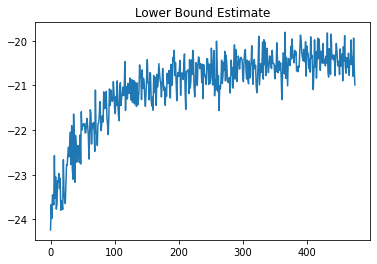

In [11]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

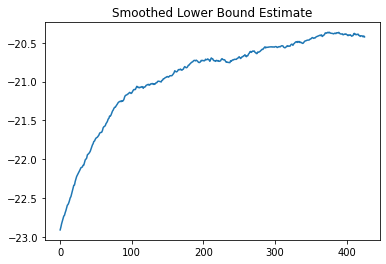

In [12]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [13]:
best_mu = best_lambda[0]

best_l = np.zeros((4, 4))
best_l[:, 0] = best_lambda[1][0:4]
best_l[1:4, 1] = best_lambda[1][4:7]
best_l[2:4, 2] = best_lambda[1][7:9]
best_l[3:4, 3] = best_lambda[1][9:10]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.51972423,  0.04640442,  1.14521122, -0.13415417])

Text(0.5, 1.0, 'Posterior density of alpha')

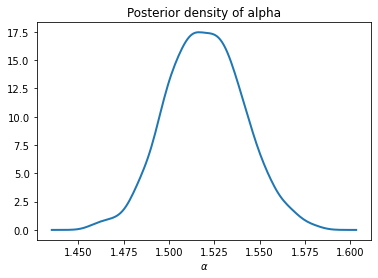

In [14]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde = gaussian_kde(best_alpha)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

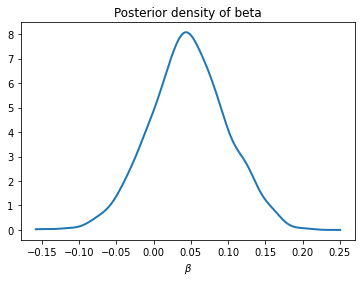

In [15]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde = gaussian_kde(best_beta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

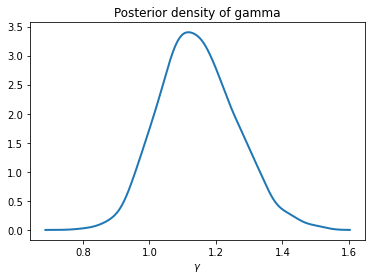

In [16]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde = gaussian_kde(best_gamma)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

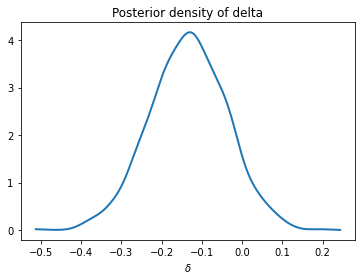

In [17]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde = gaussian_kde(best_delta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')